In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import price_filter
%matplotlib inline

In [2]:
# sudo pip install requests PIL -U

In [3]:
import googlemaps

In [4]:
import gmaps as gm

In [5]:
subte = pd.read_csv('../data/varios/estaciones-de-subte.csv',delimiter=',')
metrobus = pd.read_csv('../data/varios/estaciones-de-metrobus.csv',delimiter=';')
ferrocarril = pd.read_csv('../data/varios/estaciones-de-ferrocarril.csv',delimiter=';')

Los datos fueron provistos por [Properati](http://www.properati.com.ar) y [Buenos Aires Data](https://data.buenosaires.gob.ar/)

Los plot's fueron creados utilizando [Google Static Maps API](https://developers.google.com/maps/documentation/static-maps/)

def subte_color(linea):
    if (linea == 'A'): return 'cyan'
    if linea == 'B' : return 'red'
    if linea == 'C': return 'blue'
    if linea == 'D' :return ''
    if linea == 'E' :return 'darkviolet'
    if linea == 'H' :return 'gold'

In [6]:
subte.rename(columns={'X':'lon','Y':'lat','ESTACION':'nombre'},inplace=True)

In [7]:
metrobus.rename(columns={'X':'lon','Y':'lat','NOMBRE':'nombre'},inplace=True)

In [8]:
ferrocarril.rename(columns={'LNG':'lon','LAT':'lat','NOMBRE':'nombre'},inplace=True)

In [9]:
subte[['lon','lat','nombre']].sample(5)

,lon,lat,nombre
48,-58.397068,-34.623110,PICHINCHA
44,-58.377581,-34.612849,BELGRANO
76,-58.405450,-34.604490,CORRIENTES
35,-58.398427,-34.609646,PASCO
79,-58.481014,-34.577797,ECHEVERR�A


In [10]:
metrobus[['lon','lat','nombre']].sample(5)

,lon,lat,nombre
140,-58.469735,-34.547045,PAROISSIEN
193,-58.369464,-34.611765,AV BELGRANO
150,-58.507503,-34.592978,CUBAS
108,-58.468331,-34.548655,CRISOLOGO LARRALDE
32,-58.381754,-34.601725,OBELISCO NORTE


In [11]:
ferrocarril[['lon','lat','nombre']].sample(5)

,lon,lat,nombre
31,-58.476278,-34.592447,P. N. ARATA
13,-58.493953,-34.601326,VILLA DEL PARQUE
36,-58.480222,-34.632203,FLORESTA
28,-58.378874,-34.653502,YRIGOYEN
25,-58.465298,-34.627581,FLORES


In [12]:
subte['color'] = 'green'

In [13]:
ferrocarril['color'] = 'red'

In [14]:
metrobus['color'] = 'lime'

In [15]:
max_lat = ferrocarril['lat'].max()
min_lat = ferrocarril['lat'].min()

max_lon = ferrocarril['lon'].max()
min_lon = ferrocarril['lon'].min()

In [16]:
subte = subte.append(subte)

In [17]:
df = subte

In [18]:
for i in range(0,5):
    df = df.append(metrobus)
    df = df.append(ferrocarril)
    df = df.append(subte)

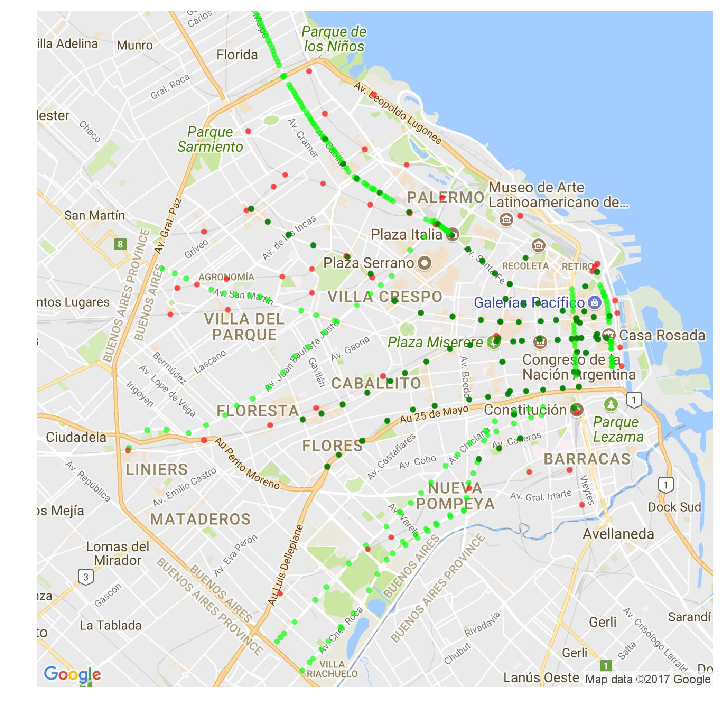

In [19]:
gm.scatter(latitudes=df.lat, longitudes=df.lon,colors=df.color)

In [20]:
properties = pd.read_csv('../data/properati_full_month.csv',low_memory=False)

In [21]:
properties.shape

(597228, 31)

In [22]:
properties = price_filter.property_filter_price(properties)

price_filter.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['zone'] = df.place_with_parent_names.apply(lambda x : x.split('|')[3])
price_filter.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  'title'],axis=1)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
properties.shape

(243749, 23)

In [24]:
properties = properties[properties['state_name'] == 'Capital Federal']

In [25]:
properties.shape

(112022, 23)

In [26]:
properties = properties[(properties['lon'] < max_lon) & (properties['lon'] > min_lon) & \
                        (properties['lat'] < max_lat) & (properties['lat'] > min_lat) ]#& \
                        #(properties['price_aprox_usd'] < 50000)]

In [27]:
properties.shape

(102784, 23)

In [28]:
def agregate_lat_lon_column(df) :
    for i in range(df.shape[0]) : 
        df.loc[i,'lat_lon'] = str(df.loc[i,'lat']) + ',' +  str(df.loc[i,'lon'])



def calculate_distace(lat_lon,estaciones) :  
    df = estaciones.copy()
    df = df[['lat','lon','lat_lon','nombre']]

    for i in range(df.shape[0]) : 
        df.loc[i,'distance'] = ((float(df.loc[i,'lat_lon'].split(',')[0]) - float(lat_lon.split(',')[0])) \
                + (float(df.loc[i,'lat_lon'].split(',')[1]) - float(lat_lon.split(',')[1])))    
    df.distance = df.distance.abs()
    return df.sort_values(by='distance',ascending=True).head(1).distance

properties_distance = properties[pd.notnull(properties['lat-lon'])].reset_index(drop=True)

properties_distance.shape

ferrocarril.columns

agregate_lat_lon_column(ferrocarril)

ferrocarril.columns

properties_distance['distance_ferrocarril'] = properties_distance['lat-lon'].apply(lambda x : calculate_distace(x,ferrocarril))

properties_distance.distance_ferrocarril.describe()

In [29]:
properties_scatter = properties[['lon','lat','property_type']]

In [30]:
def property_type_color(atype):
    if atype == 'apartment': return 'lightcyan' 
    if atype == 'house' :return 'mediumblue'
    if atype == 'PH' :return 'salmon'
    if atype == 'store' : return 'indigo'

In [31]:
properties_scatter['color'] = properties_scatter.property_type.apply(property_type_color)

/home/brahvic/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


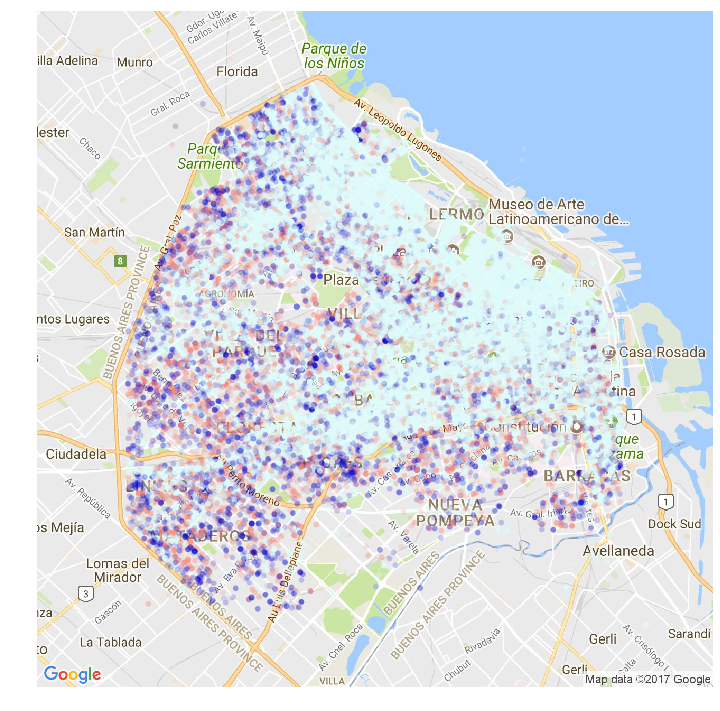

In [32]:
gm.scatter(latitudes=properties_scatter.lat,longitudes=properties_scatter.lon,colors=properties_scatter.color)

In [33]:
other_frame = properties_scatter.append(df)

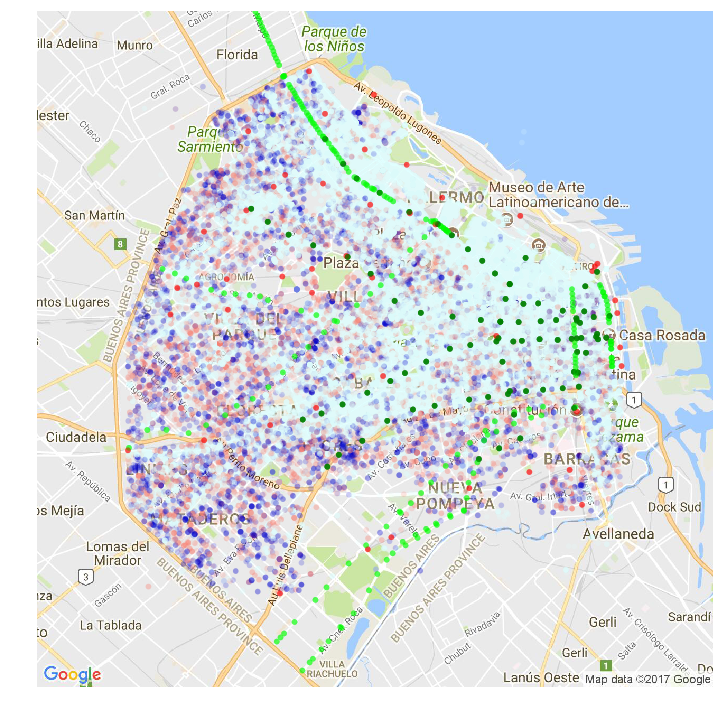

In [34]:
gm.scatter(latitudes=other_frame.lat, longitudes=other_frame.lon,colors=other_frame.color)

#### Los departamentos(apartment) estan representados por lightcyan, las casas(house) por mediumblue, los pisos (PH) por salmon, los locales (store) por indigo, los red de subtes por green , la red de metrobus por lime y las estaciones de trenes por red

#  Plot de densidad de publicaciones

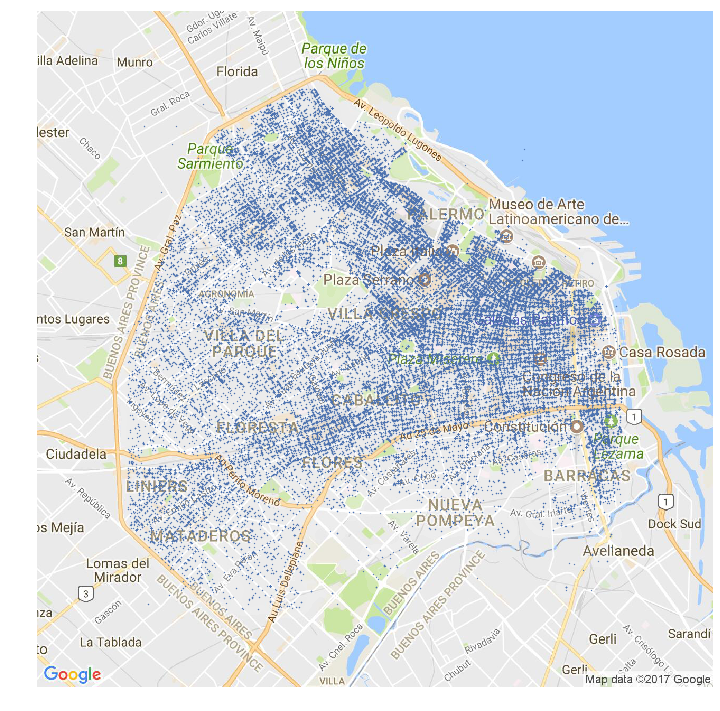

In [35]:
gm.density_plot(latitudes=properties.lat, longitudes=properties.lon)

In [ ]:

# Lista de pendiente
###    ·Agregar informacion sobre el transporte y visualizar cual es la influencia de estos en el precio, teniendo en cuenta la distancia
###    ·Agregar informacion sobre los espacios verdes y visualizar el efecto de estos en el precio de las propiedades
